# Part A
You should only need to run this once, after that can simply load in the saved images as done in part B.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os

script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = os.path.abspath(os.path.join(script_dir, "..", "..", "data_processed"))
file_path = os.path.join(data_dir, "morphology_focus.tif")

In [2]:
%matplotlib widget

# Open the .tif file
img = Image.open(os.path.join(data_dir, "morphology_focus.tif"))


# Convert to numpy array
image_array = np.array(img)

# Calculate the quantile to scale intensity
quantile_value = np.quantile(image_array, 0.99)

# Scale intensity by dividing by the quantile
scaled_image_array = image_array / quantile_value

# Clip values greater than 1 to ensure image is within [0, 1] range
img2 = np.clip(scaled_image_array, 0, 1)

# Display the scaled image
# plt.imshow(img2, cmap='gray')  # Uncomment this line and below to display the whole image (this runs slow)
# plt.show()

In [3]:
cell_boundaries = pd.read_csv(os.path.join(data_dir, "cell_boundaries.csv.gz"))
cell_boundaries["vertex_x_trans"] = cell_boundaries["vertex_x"].apply(
    lambda x: int(x / 0.2125)
)
cell_boundaries["vertex_y_trans"] = cell_boundaries["vertex_y"].apply(
    lambda x: int(x / 0.2125)
)

In [4]:
clusters = pd.read_csv(os.path.join(data_dir, "clusters.csv"))
ncells = clusters.shape[0]
ncells

36553

In [5]:
img_pix = np.array(img)

In [6]:
random.seed(2024)

ncells_subset = 1000

cells_subset = random.sample(range(ncells), ncells_subset)

# clusters.loc[cells_subset, "Cluster"]

for i in cells_subset:
    # extract the boundary vertices for the selected cell
    bounds_i = cell_boundaries.loc[cell_boundaries["cell_id"] == i]

    # extract the cluster value for the selected cell
    clustval_i = clusters.loc[i, "Cluster"]

    # extract the pixel intensities for the area covering the cell boundary
    img_sub = img_pix[
        min(bounds_i["vertex_y_trans"]) : max(bounds_i["vertex_y_trans"]),
        min(bounds_i["vertex_x_trans"]) : max(bounds_i["vertex_x_trans"]),
    ]

    # normalise the pixel intensities according to 99th percentile
    img_sub_norm = img_sub / np.quantile(img_sub, 0.99)

    # as an example, display the image for the first selected cell
    if i in cells_subset[0:5]:
        print(f"Displaying image for cell {i}")
        # plt.imshow(img_sub_norm, cmap="gray")  # Uncomment this line and below to display sample cell images
        # plt.show()

    # create directory for images if it doesn't exist
    cell_dir = os.path.join(os.getcwd(), data_dir, "cell_images_py")
    if not os.path.exists(cell_dir):
        os.mkdir(cell_dir)

    # create directory for cluster if it doesn't exist
    clust_dir = os.path.join(cell_dir, f"cluster_{clustval_i}")
    if not os.path.exists(clust_dir):
        os.mkdir(clust_dir)

    # save extracted image as a png file
    plt.imsave(os.path.join(clust_dir, f"cell_{i}.png"), img_sub_norm, cmap="gray")

Displaying image for cell 30807
Displaying image for cell 11908
Displaying image for cell 19906
Displaying image for cell 13120
Displaying image for cell 26875


# Part B

### Setup

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import re

In [8]:
DATA_DIRECTORY = data_dir
CELL_IMAGES = os.path.join(DATA_DIRECTORY, "cell_images_py")
SIZE = (224, 224)

## Loading in and displaying images

In [9]:
def get_cluster_images(cluster: int, size=(None, None)):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    return [
        Image.open(file).convert("L")
        if None in size
        else Image.open(file).convert("L").resize(size)
        for file in files
    ]

In [10]:
# cluster_A_files = os.path.join(CELL_IMAGES, os.listdir(os.path.join(CELL_IMAGES, 'cluster_8')))
cluster_A_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_8"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_8"))
]
cluster_B_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_13"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_13"))
]

In [11]:
cluster_A_images = get_cluster_images(8)
cluster_B_images = get_cluster_images(13)
cluster_A_images_resized = get_cluster_images(8, size=SIZE)
cluster_B_images_resized = get_cluster_images(13, size=SIZE)

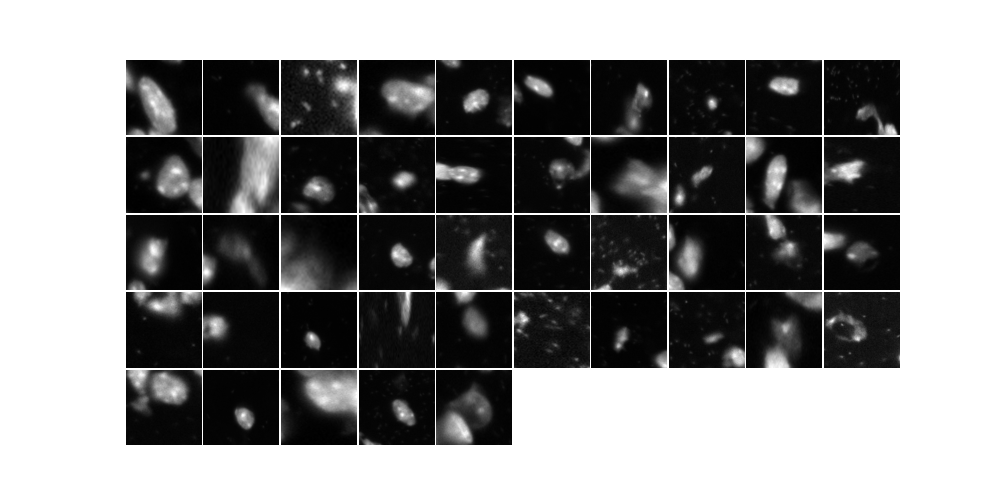

In [12]:
def display_images_in_grid(images, ncols=3, cmap=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig_height = (
        nrows * 1
    )  # Adjust the multiplier as needed to control spacing between rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, fig_height))

    for ax in axes.flat:
        ax.axis("off")

    for i, image in enumerate(images):
        ax = axes[i // ncols, i % ncols]
        if not cmap:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)

    plt.subplots_adjust(wspace=0.01, hspace=0.03)  # Adjust spacing between subplots
    plt.show()


display_images_in_grid(cluster_A_images_resized, ncols=10, cmap="gray")

## Cell boundary and masking

### Setup

In [13]:
from shapely.geometry import Polygon
import rasterio
from rasterio.features import geometry_mask
from skimage.draw import polygon2mask

In [14]:
cell_boundaries_raw = pd.read_csv(
    os.path.join(DATA_DIRECTORY, "cell_boundaries.csv.gz")
)



def get_cluster_cell_ids(cluster: int):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    pattern = r"cell_(\d+)\.png"
    return [int(re.search(pattern, file).group(1)) for file in files]


cluster_A_cell_ids = get_cluster_cell_ids(8)
cluster_B_cell_ids = get_cluster_cell_ids(13)

### Masking one cell

In [15]:
cell_boundaries = cell_boundaries_raw.loc[
    cell_boundaries_raw["cell_id"].isin(cluster_A_cell_ids + cluster_B_cell_ids)
]

In [16]:
def get_masked_image(
    image: Image, cell_id: int, cell_boundaries: pd.core.frame.DataFrame
):
    height, width = np.array(image).shape
    cell_boundary = cell_boundaries[cell_boundaries["cell_id"] == cell_id].copy()
    cell_boundary["vertex_x_scaled"] = 1 + (
        (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min()) * scaling_factor
    )
    cell_boundary["vertex_y_scaled"] = 1 + (
        (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min()) * scaling_factor
    )
    polygon = np.array(
        list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
    )
    mask = polygon2mask((height, width), polygon)
    masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)
    return masked_image

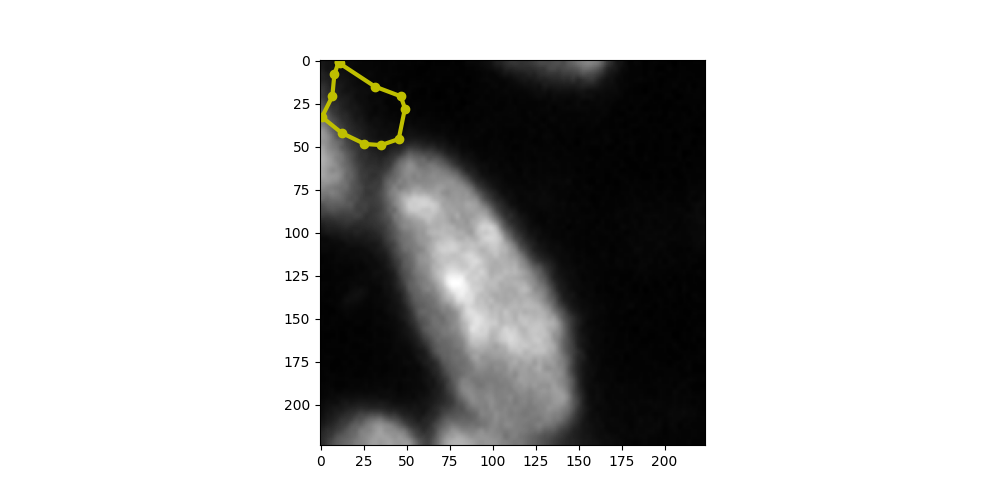

In [17]:
index = 0

cell_boundary = cell_boundaries[
    cell_boundaries["cell_id"] == cluster_A_cell_ids[index]
].copy()
img_A = cluster_A_images[index].convert("L")
img_A_resized = cluster_A_images_resized[index].convert("L")

# Calculate scaling factor
scaling_factor = 1 / 0.22
height, width = np.array(img_A).shape

# Calculate scaled x and y coordinates
cell_boundary["vertex_x_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
            * scaling_factor
        )
    )
    * 50
    / width
)
cell_boundary["vertex_y_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
            * scaling_factor
        )
    )
    * 50
    / height
)

# Visualize the image
plt.clf()
plt.imshow(img_A_resized, cmap="gray")
plt.plot(
    cell_boundary["vertex_x_scaled"],
    cell_boundary["vertex_y_scaled"],
    "y-o",
    linewidth=3,
)
plt.show()

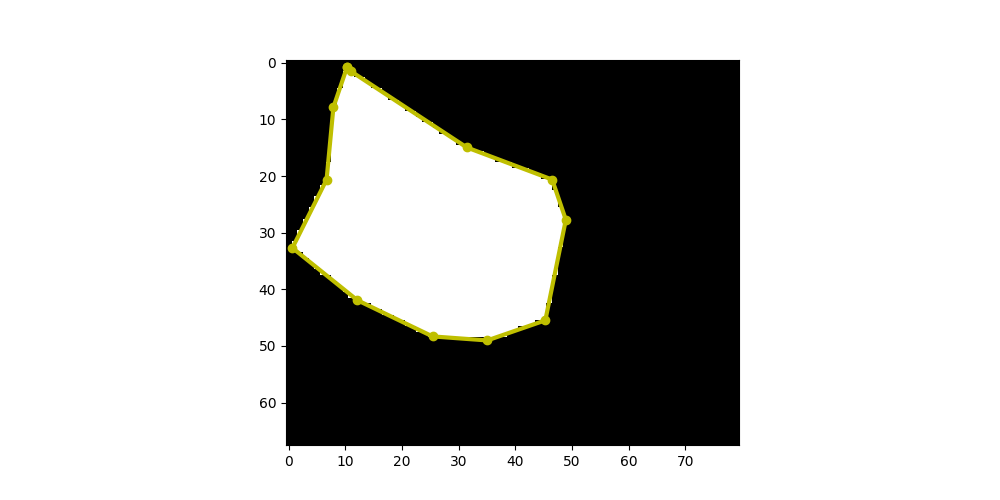

In [18]:
height, width = np.array(img_A.convert("L")).shape
polygon = np.array(
    list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
)
mask = polygon2mask((height, width), polygon)
masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)

# Display the masked image
# result = np.where(masked_image.mask, 0, masked_image)  # image with mask
result = np.where(masked_image.mask, 0, 1)  # just the mask
plt.imshow(result, cmap="gray")
plt.show()

### Masking all cells

In [19]:
def get_cluster_masked_images(cluster: int, size=(None, None)):
    images = get_cluster_images(cluster)
    if None not in size:  # get resized images if size is specified
        images_resized = get_cluster_images(cluster, size)

    cell_ids = get_cluster_cell_ids(cluster)
    cell_boundaries = cell_boundaries_raw.loc[
        cell_boundaries_raw["cell_id"].isin(cell_ids)
    ].copy()

    # Calculate scaling factor
    scaling_factor = 1 / 0.22

    result = {}
    for cell_id, image, image_resized in zip(cell_ids, images, images_resized):
        # get shape of original image (without resize)
        height, width = np.array(image).shape
        # scaling factor for cell boundary, only if size is given
        resize_x = 50 / width if None not in size else 1
        resize_y = 50 / height if None not in size else 1

        # get cell boundary coordinates for the image
        cell_boundary = cell_boundaries.loc[
            cell_boundaries["cell_id"] == cell_id
        ].copy()
        # Calculate scaled x and y coordinates
        cell_boundary["vertex_x_scaled"] = (
            1
            + (
                (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
                * scaling_factor
            )
        ) * resize_x
        cell_boundary["vertex_y_scaled"] = (
            1
            + (
                (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
                * scaling_factor
            )
        ) * resize_y

        # create the mask
        polygon = np.array(
            list(
                zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"])
            )
        )
        mask = polygon2mask((height, width) if None in size else SIZE, polygon)
        # mask the image
        #masked_image = np.ma.masked_array(
            #np.copy(image if None in size else image_resized),
            #np.invert(mask),
            #fill_value=0,
        #)
        result[cell_id] = np.copy(image if None in size else image_resized)

    return result

In [20]:
masked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE) for cluster in range(1, 29)
}

In [21]:
# display_images_in_grid(masked_cells[1])
plt.imshow(masked_cells[8][33839], cmap="gray")

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_and_display_contours(
    img,
    canny_threshold1=10,
    canny_threshold2=200,
    contour_color=(0, 255, 0),
    contour_thickness=1,
):
    # Use Canny edge detection
    canny = cv2.Canny(img, canny_threshold1, canny_threshold2)

    # Find contours
    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    print("Number of Contours =", len(contours))

    # Create an image copy to draw contours on
    display_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img, contours, -1, contour_color, contour_thickness)
    display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2GRAY)

    # Convert BGR to RGB for displaying in matplotlib
    display_img_rgb = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)

    # Display using matplotlib
    #plt.close()
    #plt.imshow(display_img_rgb)
    #plt.title("Contours")
    #plt.axis("off")  # Hide axes
    #plt.show()

    return img

processed_cells = {}
for cluster, inner_dict in masked_cells.items():
    processed_cells[cluster] = {}
    for number, cell in inner_dict.items():
        processed_cells[cluster][number] = process_and_display_contours(cell)


Number of Contours = 0
Number of Contours = 1
Number of Contours = 6
Number of Contours = 3
Number of Contours = 3
Number of Contours = 8
Number of Contours = 6
Number of Contours = 3
Number of Contours = 1
Number of Contours = 5
Number of Contours = 0
Number of Contours = 0
Number of Contours = 1
Number of Contours = 12
Number of Contours = 3
Number of Contours = 4
Number of Contours = 13
Number of Contours = 7
Number of Contours = 9
Number of Contours = 0
Number of Contours = 0
Number of Contours = 1
Number of Contours = 3
Number of Contours = 5
Number of Contours = 2
Number of Contours = 4
Number of Contours = 3
Number of Contours = 0
Number of Contours = 3
Number of Contours = 0
Number of Contours = 1
Number of Contours = 0
Number of Contours = 0
Number of Contours = 0
Number of Contours = 0
Number of Contours = 0
Number of Contours = 0
Number of Contours = 7
Number of Contours = 17
Number of Contours = 7
Number of Contours = 9
Number of Contours = 1
Number of Contours = 5
Number o

## Deep Learning

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

### Make the dataset

In [24]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from PIL import Image
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, images_dict, transform=None):
        self.images_dict = images_dict
        self.labels = []
        self.images = []
        for cluster, images in images_dict.items():
            self.images.extend(images.values())
            self.labels.extend([cluster - 1] * len(images))
        self.transform = transform  # Transformation to apply to each image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)  # Apply transformation

        # Convert label to PyTorch tensor
        label_tensor = torch.tensor(label, dtype=torch.long)

        return image, label_tensor

#### Load data and create dataloaders

In [33]:
from torchvision import transforms

train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5], [0.5]
        ),  # Example normalization, adjust as necessary
        
    ]
)

# Pass these transformations when creating the dataset instance

custom_dataset = CustomDataset(masked_cells, transform=train_transforms)

# Define the sizes of the training, validation, and testing sets
train_size = int(0.6 * len(custom_dataset))  # 60% for training
val_size = int(0.2 * len(custom_dataset))  # 20% for validation
test_size = len(custom_dataset) - train_size - val_size  # Remaining for testing

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(
    custom_dataset, [train_size, val_size, test_size]
)

# Define batch size and other DataLoader parameters
batch_size = 32
shuffle = True

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for testing set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### ResNet50

In [26]:
import torchvision.models as models
import torch.nn.functional as F


class ModifiedResNet50(models.ResNet):
    def __init__(self, weights=None, *args, **kwargs):
        super(ModifiedResNet50, self).__init__(
            block=models.resnet.Bottleneck, layers=[3, 4, 6, 3], *args, **kwargs
        )

        if weights is not None:
            self.load_state_dict(weights.get_state_dict(progress=True))

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            original_first_layer = weights.get_state_dict()["conv1.weight"]
            self.conv1.weight.data = original_first_layer.mean(dim=1, keepdim=True)

        # Adding Dropout
        self.dropout = nn.Dropout(0.5)

        # Adding Batch Normalization
        self.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [34]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a modified Vision Transformer (ViT) with a dropout layer
class ModifiedViT(nn.Module):
    def __init__(
        self,
        model_name="vit_base_patch16_224",
        pretrained=True,
        num_classes=1000,
        dropout_rate=0.5,  # Default dropout rate
    ):
        super(ModifiedViT, self).__init__()
        
        # Load the pretrained ViT model
        self.vit = timm.create_model(
            model_name, pretrained=pretrained, num_classes=num_classes
        )

        # Modify the patch embedding to handle grayscale images
        original_patch_embedding = self.vit.patch_embed.proj
        self.vit.patch_embed.proj = nn.Conv2d(
            1,
            original_patch_embedding.out_channels,
            kernel_size=original_patch_embedding.kernel_size,
            stride=original_patch_embedding.stride,
            padding=original_patch_embedding.padding,
            bias=False,
        )

        # If using pretrained weights, adjust for grayscale
        if pretrained:
            with torch.no_grad():
                original_weight = original_patch_embedding.weight.mean(
                    dim=1, keepdim=True
                )
                self.vit.patch_embed.proj.weight.data = original_weight

        # Add dropout layer after patch embedding
        self.dropout = nn.Dropout(p=dropout_rate)

        # Replace the classifier head
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        x = self.vit.patch_embed(x)

        cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        
        # Apply positional dropout and add positional embedding
        x = self.vit.pos_drop(x + self.vit.pos_embed)
        
        # Apply dropout before entering transformer blocks
        x = self.dropout(x)

        # Forward through the transformer blocks
        x = self.vit.blocks(x)
        
        # Apply normalization
        x = self.vit.norm(x)
        
        # Select CLS token and apply final dropout
        x = self.dropout(x[:, 0])
        
        # Final classifier head
        x = self.vit.head(x)

        return x



### Train

In [35]:
from tqdm import tqdm


def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-4
    )

    # Move model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Lists to store training and validation loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_loop = tqdm(train_loader, total=len(train_loader), leave=True, position=0)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Print progress
        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}, "
            f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}"
        )

    # Return training and validation losses and accuracies
    return train_losses, val_losses, train_accuracies, val_accuracies

In [36]:
from torch import device, Tensor
import torchvision.models as models
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights

# Load the pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedViT().to(device)

In [ ]:
t_loss, v_loss, t_acc, v_acc = train_model(model, train_loader, val_loader,num_epochs= 30)
lab_model_results = {"t_loss": t_loss, "v_loss": v_loss, "t_acc": t_acc, "v_acc": v_acc}

100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


Epoch [1/30], Training Loss: 5.5262, Training Accuracy: 0.0433, Validation Loss: 3.4481, Validation Accuracy: 0.0900


100%|██████████| 19/19 [00:10<00:00,  1.78it/s]


Epoch [2/30], Training Loss: 3.6041, Training Accuracy: 0.0667, Validation Loss: 3.3666, Validation Accuracy: 0.0500


100%|██████████| 19/19 [00:10<00:00,  1.75it/s]


Epoch [3/30], Training Loss: 3.5155, Training Accuracy: 0.0817, Validation Loss: 3.2279, Validation Accuracy: 0.1150


100%|██████████| 19/19 [00:11<00:00,  1.66it/s]


Epoch [4/30], Training Loss: 3.4771, Training Accuracy: 0.0700, Validation Loss: 3.2074, Validation Accuracy: 0.1000


100%|██████████| 19/19 [00:12<00:00,  1.57it/s]


Epoch [5/30], Training Loss: 3.4315, Training Accuracy: 0.0883, Validation Loss: 3.2731, Validation Accuracy: 0.0800


100%|██████████| 19/19 [00:12<00:00,  1.55it/s]


Epoch [6/30], Training Loss: 3.3501, Training Accuracy: 0.0700, Validation Loss: 3.2503, Validation Accuracy: 0.0950


100%|██████████| 19/19 [00:12<00:00,  1.52it/s]


Epoch [7/30], Training Loss: 3.2839, Training Accuracy: 0.0883, Validation Loss: 3.2833, Validation Accuracy: 0.1100


100%|██████████| 19/19 [00:12<00:00,  1.50it/s]


Epoch [8/30], Training Loss: 3.3243, Training Accuracy: 0.0883, Validation Loss: 3.3331, Validation Accuracy: 0.1150


100%|██████████| 19/19 [00:12<00:00,  1.52it/s]


Epoch [10/30], Training Loss: 3.2358, Training Accuracy: 0.0767, Validation Loss: 3.2599, Validation Accuracy: 0.1100


 42%|████▏     | 8/19 [00:05<00:07,  1.55it/s]

In [31]:
def generate_plots(train_losses, val_losses, train_accuracies, val_accuracies):
    with plt.style.context("dark_background"):
        # Generate x-axis values (epochs)
        epochs = range(1, len(train_losses) + 1)

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Plot training and validation losses
        ax1.plot(epochs, train_losses, label="Training Loss", marker="o")
        ax1.plot(epochs, val_losses, label="Validation Loss", marker="o")

        # Add jitter to the data points for better visualization
        ax1.scatter(epochs, train_losses, color="blue")
        ax1.scatter(epochs, val_losses, color="orange")

        # Add labels and legend for the first subplot
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title("Training and Validation Loss")
        ax1.legend()

        # Plot training and validation accuracies
        ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
        ax2.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")

        # Add jitter to the data points for better visualization
        ax2.scatter(epochs, train_accuracies, color="green")
        ax2.scatter(epochs, val_accuracies, color="red")

        # Add labels and legend for the second subplot
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.set_title("Training and Validation Accuracy")
        ax2.legend()

        # Adjust layout
        plt.tight_layout()

        # Show plot
        plt.show()

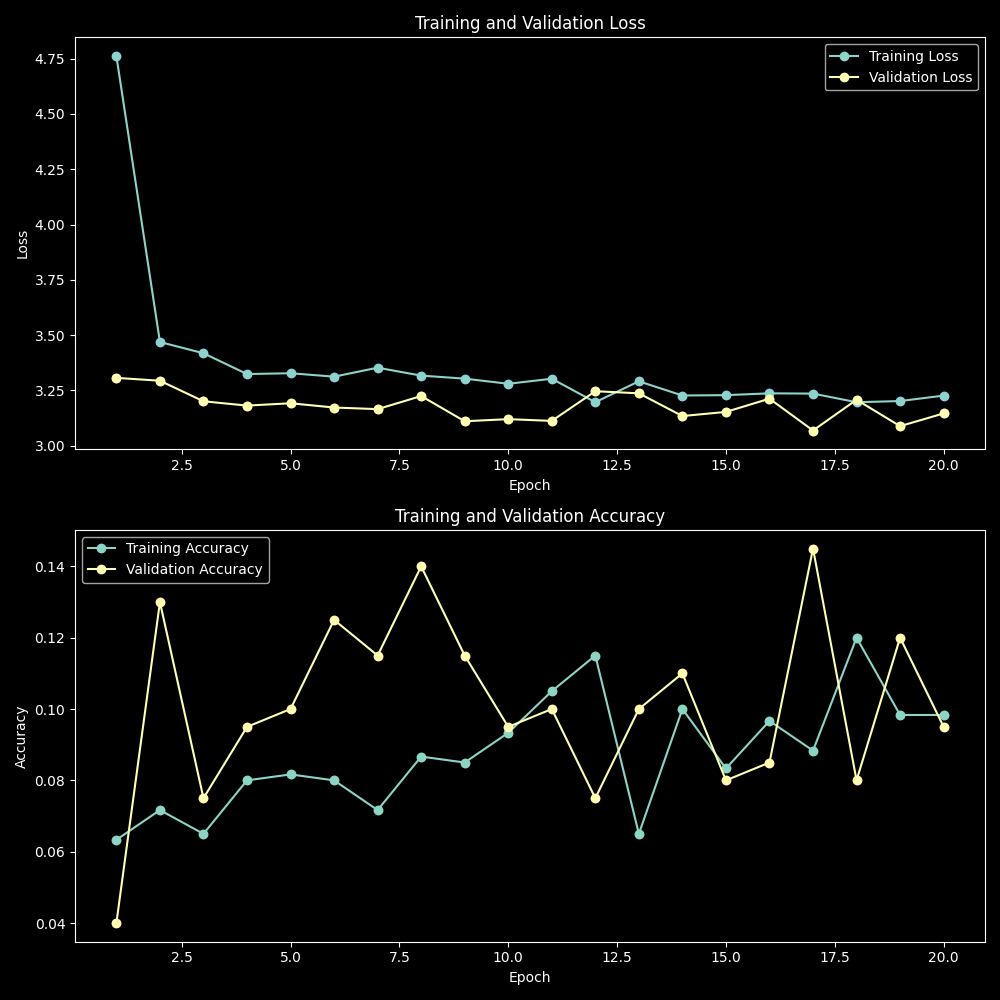

In [32]:
generate_plots(t_loss, v_loss, t_acc, v_acc)
